In [1]:
# Загрузка нужных библиотек
import numpy as np
from scipy.stats import gamma, beta, lognorm, norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Отключение ворнингов
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

Подход заключается в минимизации квадратов разности на заданных перцентил.
У нас есть значения квантилей:
$$
\begin{align*}
q_{0.05}&=f(0.05,\theta)\\
q_{0.5}&=f(0.5,\theta)\\
q_{0.95}&=f(0.95,\theta)\\
\end{align*}
$$
И у нас есть мат. ожидание $E[\theta]$

$$
\begin{align*}
k_1\cdot(q_{0.05}-f(0.05,\theta))^2+k_2\cdot(q_{0.5}-f(0.5,\theta))^2 + k_3\cdot(q_{0.95}-f(0.95,\theta))^2 \rightarrow min
\end{align*}
$$
при
$$k1_1=k_2=k_3=const$$

Законы распределения параметризируем через мат. ожидание $E[\theta]$ и параметр формы, который как раз и будем подбирать.

In [2]:
# Функция выполняет подгон параметра распределения для заданного закона распределения
def distr_fit(distr_type ,quantiles, probabilities, expectation, k=1, bounds=np.array([1e-3, 1e+3])):
    # Задаём функцию ошибки
    func = {
        'gamma': lambda x:
        (k*(gamma.ppf(quantiles, a=x, scale=expectation/x)-probabilities)**2).sum(),

        'beta': lambda x:
        (k*(beta.ppf(quantiles, a=x, b=x/expectation-x)-probabilities)**2).sum(),
        
        'lognorm': lambda EF:
        (k*(lognorm.ppf(quantiles, s=np.log(EF)/1.6449, scale = expectation)-probabilities)**2).sum(),
        
        'norm': lambda sigma:
        (k*(norm.ppf(quantiles, loc=expectation, scale=sigma)-probabilities)**2).sum()
    }.get(distr_type, None)
    if func is None: return None
    # Минимизируем функцию ошибки по одному параметру
    res = minimize_scalar(func, bounds=bounds, method='bounded')
    # Возвращаем параметр
    return res.x

В ПО RiskSpectrum даются ограничения на допустимые значения параметров распределения:
* Both for gamma and beta distributions the shape parameter $\alpha$ is limited to be $0.1 \leq \alpha \leq 20.0$.
* The error factor (EF) used for lognormal distributions must be $1 < EF < 10000$
* The standard deviation for the normal distribution is limited to be less than approximately 60.8% of the mean value. If the standard deviation is higher, a considerable tail of the distribution extends out on the negative domain, which cannot be allowed for any of the parameter types. Actually, distributions with 0% and 1% percentiles lower than 0 are accepted, but in that case these percentiles are truncated to 0.

In [3]:
# FC JNID/IL 3.23E-07 4.04E-07 4.07E-07 4.97E-07

# Задаём перцентили
q = np.array([0.05, 0.5, 0.95])
# Задаём значения перцентилей
d = np.array([3.23E-07 , 4.04E-07, 4.97E-07])
# Задаём мат. ожидание (mean)
m = 4.07E-07
# Название для рисования графиков
name = 'FC_JNID_IL'

# Вызываем функцию подгонки для каждого типа распределения,
# с учётом ограничений на допустимые значения параметров в RiskSpec
a_gamma  = distr_fit('gamma', q, d, m, bounds=[0.1,20])
a_beta = distr_fit('beta', q, d, m, bounds=[0.1,20])
a_lognorm = distr_fit('lognorm', q, d, m, bounds=[1,10000])
a_norm = distr_fit('norm', q, d, m, bounds =[0, 0.608*m])

print(f'Gamma: param={a_gamma:0.5}\n',
      f'Beta: param={a_beta:0.5}\n',
      f'Lognorm: param={a_lognorm:0.5}\n', 
      f'Norm: param={a_norm:0.5}')

Gamma: param=20.0
 Beta: param=20.0
 Lognorm: param=1.2327
 Norm: param=9.452e-08


In [4]:
# Настройка стиля рисунков
# Включение модного, черного стиля для рисунков
#plt.style.use('dark_background')
# Изменение стандартного шрифта на Linux-своместимый
#plt.rcParams["font.family"] = 'Liberation Mono'
# Изменяем стандартный размер шрифта
plt.rcParams.update({'font.size': 12})
# Изменяем стандартный размер картинки
plt.rcParams['figure.figsize'] = [8, 8]

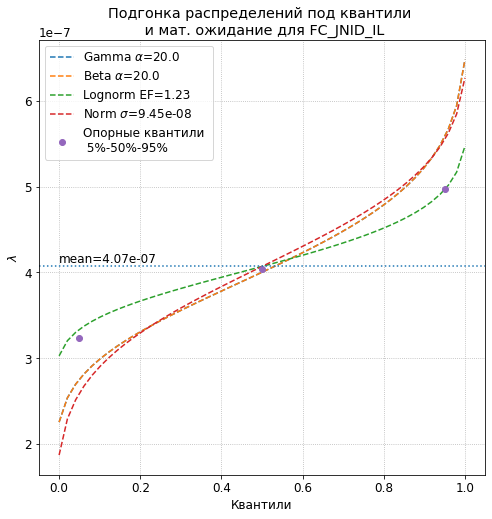

In [5]:
# Рисуем график вероятностного распределения
# https://en.wikipedia.org/wiki/Quantile_function

x = np.linspace(0,1)
qq = np.linspace(0.01,0.99)
plt.plot(x, gamma.ppf(qq, a=a_gamma, scale=m/a_gamma), '--')
plt.plot(x, beta.ppf(qq, a=a_beta, b=a_beta/m-a_beta), '--')
plt.plot(x, lognorm.ppf(qq, s=np.log(a_lognorm)/1.6449, scale= m), '--')
plt.plot(x, norm.ppf(qq, loc=m, scale=a_norm), '--')
plt.plot(q, d,'o')
plt.ylabel('$\lambda$')
plt.xlabel('Квантили')
plt.legend([f'Gamma $\\alpha$={a_gamma:0.3}',
            f'Beta $\\alpha$={a_beta:0.3}',
            f'Lognorm EF={a_lognorm:0.3}', 
            f'Norm $\\sigma$={a_norm:0.3}',
            f'Опорные квантили \n 5%-50%-95%'])

plt.title(f'Подгонка распределений под квантили \n и мат. ожидание для {name}')
plt.grid(linestyle=':')
plt.text(0, m*1.01, f'mean={m}')
plt.axhline(m, ls=':')
# Сохранение графика в файл. 
plt.savefig(f'distribution_fitting_{name}.svg', format="svg" , transparent=True)

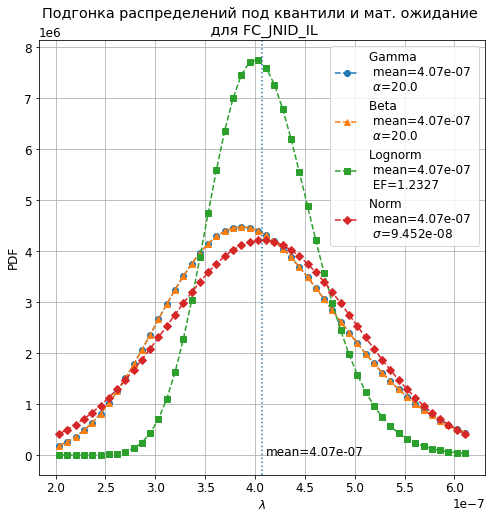

In [6]:
# Рисуем график плотности
x = np.linspace(0.5*m,1.5*m)
plt.plot(x, gamma.pdf(x, a=a_gamma, scale=m/a_gamma), 'o--')
plt.plot(x, beta.pdf(x, a=a_beta, b=a_beta/m-a_beta), '^--')
plt.plot(x, lognorm.pdf(x, s=np.log(a_lognorm)/1.6449, scale= m), 's--')
plt.plot(x, norm.pdf(x, loc=m, scale=a_norm), 'D--')
plt.ylabel('PDF')
plt.xlabel('$\lambda$')
plt.legend([f'Gamma \n mean={m:0.3} \n $ \\alpha$={a_gamma:0.5}',
            f'Beta \n mean={m:0.3} \n $ \\alpha$={a_beta:0.5}',
            f'Lognorm \n mean={m:0.3} \n EF={a_lognorm:0.5}', 
            f'Norm \n mean={m:0.3} \n $ \\sigma$={a_norm:0.5}'])

plt.title(f'Подгонка распределений под квантили и мат. ожидание \n для {name}')
plt.grid(':')
plt.text(m*1.01, 0, f'mean={m}')
plt.axvline(m, ls= ':')
plt.savefig(f'quantile_fitting_{name}.svg', format="svg" , transparent=True)